# Recreating the N-BEATS Algorithm

The paper to be replicated is available here: https://arxiv.org/pdf/1905.10437.pdf

## Preparation

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import pandas as pd

Helper functions

In [2]:
def mean_absolute_scaled_error(y_true,y_pred):
  """
  implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1])) # our seasonality is 1 day, hence the shift of 1

  return mae/mae_naive_no_season
  

In [3]:
def make_preds(model,input_data):
  """
  uses model to make predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions


In [4]:
def evaluate_preds(y_true,y_pred):
  y_true = tf.cast(y_true,tf.float32)
  y_pred = tf.cast(y_pred,tf.float32)
  result = {}
  result["MAE"] = tf.metrics.mean_absolute_error(y_true,y_pred).numpy()
  result["MAPE"] = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred).numpy()
  result["MASE"] = mean_absolute_scaled_error(y_true,y_pred).numpy()
  result["MSE"] = tf.metrics.mean_squared_error(y_true,y_pred).numpy()
  result["RMSE"] = tf.sqrt(tf.metrics.mean_squared_error(y_true,y_pred)).numpy()
  return result
  

## Execution

Retrieve data

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

# read in bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas col 1 is datetime

bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})

--2023-03-01 23:53:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-03-01 23:53:48 (7.15 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



Create train and test sets

In [8]:
WINDOW_SIZE = 7
HORIZON = 1

# add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

# make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price",axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# make train and test sets
split_size = int(0.8*len(X))

X_train = X[:split_size]
y_train = y[:split_size]

X_test = X[split_size:]
y_test = y[split_size:]

len(X_train),len(y_train),len(X_test),len(y_test)

(2224, 2224, 556, 556)

Create fast-loading tf.data Datasets

In [9]:
BATCH_SIZE = 1024

train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_features_dataset,train_labels_dataset))
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_features_dataset,test_labels_dataset))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Create NBeatsBlock custom layer

In [10]:
HORIZON = 1
WINDOW_SIZE = 7
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

In [11]:
# create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
  
    # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)

    # so that we can use all of these arguments within the class:
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # now, the logic:
    # block contains stack of 4 fully connected layers, each with relu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons,activation="relu") for _ in range(n_layers)]

    # output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size,activation="linear",name="theta")

  def call(self,inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # output the backcast and forecast from theta
    backcast = theta[:, :self.input_size]
    forecast = theta[:, -self.horizon:]
    return backcast, forecast

Build, compile, and fit the N-BEATS algorithm:

1. Set up an instance of the NBeatsBlock layer. (This will be the initial block used for the network. The rest will be created as part of stacks.)
2. Create an input layer for the N-BEATS stack using the keras functional API.
3. Make the initial backcast and forecast for the model with the layer created in 1.
4. Use a `for` loop to create stacks of block layers.
5. Use the NBeatsBlock class within the `for` loop in 4 to create blocks which return backcasts and block-level forecasts.
6. Create double residual stacking using subtract and add layers.
7. Put the model inputs and outputs together using tf.keras.Model().
8. Compile the model with MAE loss. Use the Adam() optimizer with default settings and an initial learning rate of 0.001 (as per section 5.2 of the N-BEATS paper).
9. Fit the N-BEATS model for 5000 epochs. Use callbacks:
* EarlyStopping: stop training early if model stops improving.
* Reduce LR on Plateau: if model stops improving, try lowering the learning to reduce how much it updates its weight each time (smaller steps toward best performance).

In [12]:
# STEP 1: set up an instance of the NBeatsBlock layer. 
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="initial_block")

# STEP 2: create an input layer for the N-BEATS stack 
stack_inputs = layers.Input(shape=(INPUT_SIZE),name="stack_input")

# STEP 3: make the initial backcast and forecast for the model 
# with the layer created in 1.
residuals,forecast = nbeats_block_layer(stack_inputs)

In [22]:
# STEP 4: use for loop to create stacks of block layers.
for i,_ in enumerate(range(N_STACKS-1)): # first stack is already created

  # STEP 5: use the NBeatsBlock class within the for loop in 4 
  # to create blocks which return backcasts and block-level forecasts.
  backcast,block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                        theta_size=THETA_SIZE,
                                        horizon=HORIZON,
                                        n_neurons=N_NEURONS,
                                        n_layers=N_LAYERS,
                                        name=f"NBeatsBlock_{i}")(residuals)
  
  # STEP 6: create double residual stacking using subtract and add layers.
  residuals = layers.subtract([residuals,backcast],name=f"subtract_{i}")
  forecast = layers.add([forecast,block_forecast],name=f"add_{i}")

In [25]:
# STEP 7: put the model inputs and outputs together using tf.keras.Model().
model_NBEATS = tf.keras.Model(stack_inputs,forecast,name="model_NBEATS")

# STEP 8: compile the model with MAE loss. 
# use the Adam() optimizer with default settings.
model_NBEATS.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(lr=0.001),
                metrics=["mae"])

# STEP 9: fit the N-BEATS model for 5000 epochs. use callbacks:
# EarlyStopping
# Reduce LR on Plateau

# have train_dataset and test_dataset
history_NBEATS = model_NBEATS.fit(train_dataset,
                        epochs=N_EPOCHS,
                        validation_data=test_dataset,
                        verbose=0,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                    patience=200,
                                                                    restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                        patience=100,
                                                                        verbose=1)])

# evaluate N-BEATS model on the test dataset
model_NBEATS.evaluate(test_dataset)


Epoch 831: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 931: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 0s 26ms/step - loss: 576.5234 - mae: 576.5234


[576.5233764648438, 576.5233764648438]

In [26]:
# make predictions with N-BEATS model
model_NBEATS_preds = make_preds(model_NBEATS,test_dataset)

# evaluate N-BEATS model preds
model_NBEATS_results = evaluate_preds(y_true=tf.squeeze(y_test),
                                 y_pred=model_NBEATS_preds)

model_NBEATS_results

1/1 [==============================] - 3s 3s/step


{'MAE': 576.5234,
 'MAPE': 2.6079679,
 'MASE': 1.0127919,
 'MSE': 1192139.6,
 'RMSE': 1091.8514}

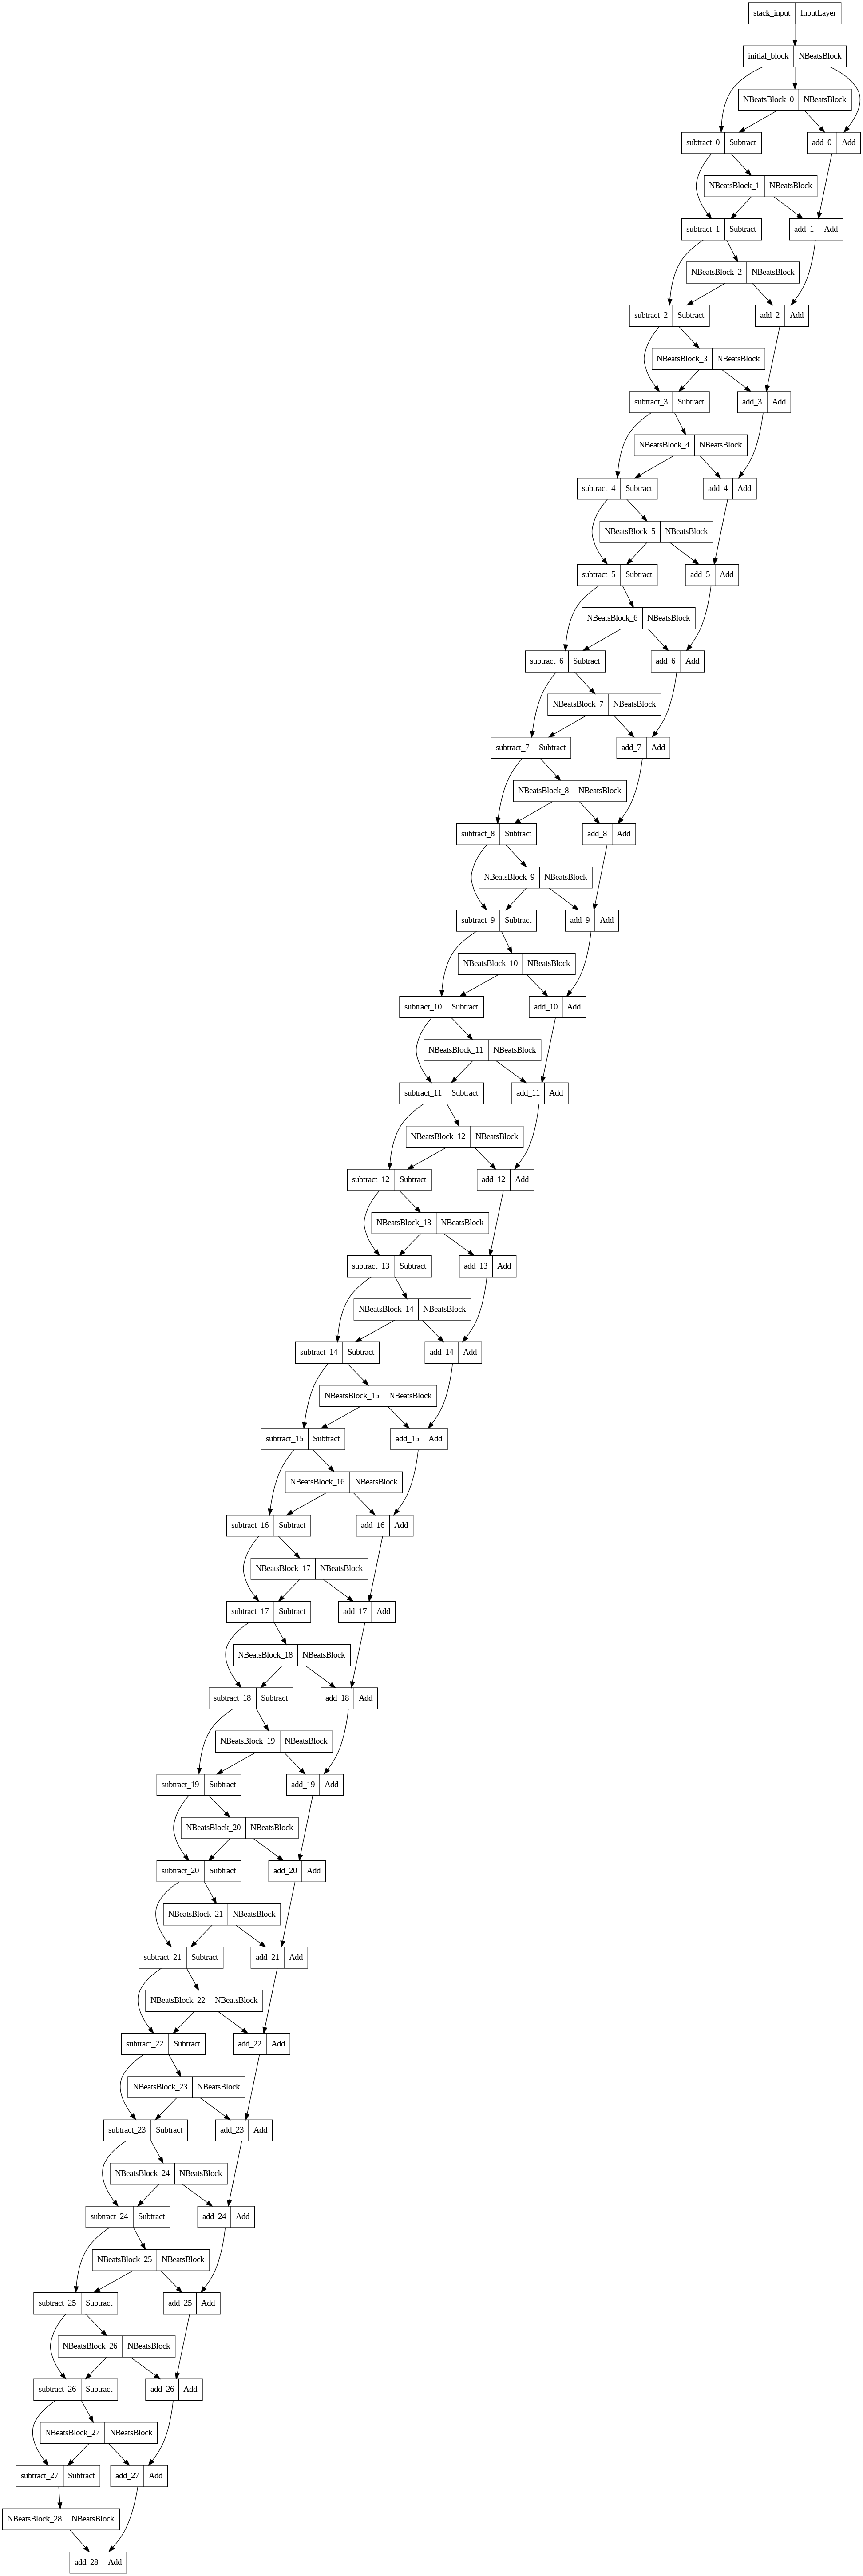

In [27]:
# plot the N-BEATS model and inspect the architecture
plot_model(model_NBEATS)